In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
plot_path=start_path+"/../plots/"
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,start_path+"/../src/")
sys.path.insert(4,synth_ar_path+"/src/")
sys.path.insert(5,synth_ar_path+"/plotting/")
sys.path.insert(6,hamp_processing_path)
sys.path.insert(7,hamp_processing_path+"/src/")
sys.path.insert(8,hamp_processing_path+"/plotting/")
sys.path.insert(9,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign

###############################################################################
#Grid Data
import reanalysis as Reanalysis
from reanalysis import ERA5,CARRA
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
from atmospheric_rivers import Atmospheric_Rivers
###############################################################################
#Radar data
import data_config
import measurement_instruments_ql
import quicklook_dicts
import halodataplot
###############################################################################
# Collocated data
from simplified_flight_leg_handling import simplified_run_grid_main
###############################################################################
# Moisture Budget Packages
import moisturebudget as Budgets
# Plot Packages
import Airborne_Budget_Plots as Airplots
###############################################################################
# Print packages
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Typhon module cannot be loaded


In [2]:
do_sensitivity_study=True

## Allocations, Switches, and Definitions

In [3]:
campaign="HALO_AC3"
flight_dates={
    "RF03":"20220313",
    "RF05":"20220315",
    "RF06":"20220316",
    "RF16":"20220410"}
##### To define: flight and AR sector-------------------------------------------------------------#
ar_of_day="AR_entire_2"
flight=["RF06"]
#-------------------------------------------------------------------------------------------------#
flight_sequence=["RF05__AR_entire_1","RF05__AR_entire_2","RF06__AR_entire_1","RF06__AR_entire_2"]
radar_sequence={}
reflectivity_for_snow="Z_g"
sector_to_plot="warm"
take_arbitary=True
do_plotting=False
calibrated_radar=True

with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)
    for rf in flight_sequence:
        ar_rf=rf.split("__")[1]
        flight_rf=[rf.split("__")[0]]
        tpm_era5,tmp_halo,tmp_cls,tmp_era5_cls,radar_sequence[rf],_=simplified_run_grid_main(
        flight=flight_rf,config_file_path=major_work_path,ar_of_day=ar_rf)

## Model data

### Reanalysis

#### 2D Field data

In [4]:
#Load config file
with HiddenPrints():
    config_file=data_config.load_config_file(major_work_path,"data_config_file")
    cmpgn_cls=flightcampaign.HALO_AC3(
                             is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=[flight],
                             instruments=["radar","radiometer","sonde"])               

    
    file_name="total_columns_"+cmpgn_cls.years[flight[0]]+"_"+\
                    cmpgn_cls.flight_month[flight[0]]+"_"+\
                    cmpgn_cls.flight_day[flight[0]]+".nc"    
    era5=Reanalysis.ERA5(for_flight_campaign=True,campaign="HALO_AC3",
                  research_flights=flight,
                  era_path=cmpgn_cls.campaign_path+"/data/ERA-5/")
    ds,era_path=era5.load_era5_data(file_name)
        
    #IVT Processing
    ds["IVT_v"]=ds["p72.162"]
    ds["IVT_u"]=ds["p71.162"]
    ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)
    ds["IVT_conv"]=ds["p84.162"]*3600 # units in seconds
ds

<xarray.Dataset>
Dimensions:    (longitude: 721, latitude: 161, time: 24)
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 50.5 50.25 50.0
  * time       (time) datetime64[ns] 2022-03-16 ... 2022-03-16T23:00:00
Data variables: (12/17)
    msl        (time, latitude, longitude) float32 ...
    siconc     (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
    tciw       (time, latitude, longitude) float32 ...
    tclw       (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
    ...         ...
    e          (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    IVT_v      (time, latitude, longitude) float32 -3.541 -3.541 ... -3.114
    IVT_u      (time, latitude, longitude) float32 -1.851 -1.851 ... 7.091 7.349
    IVT        (time, latitude, longitude) float32 3.995 3.995 ... 7.473 7.981
    IVT_conv   (time, latitude, longitude) float32 -0.7257 -0.7257 ... 0.06654
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-01 10:37:39 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### ICON-2km

#### 2D Field data

In [5]:
# load hydrometeor ICON files for precipitation
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
        central_hour="12"
    else:
        central_hour="14"
elif flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
        central_hour="12"
    else:
        central_hour="13"
hydro_fpath=major_work_path+campaign+"/data/ICON_LEM_2km/"+flight[0]+"/"
hydro_file="Hydrometeor_ICON_"+flight[0]+"_"+ar_of_day+"_"+central_hour+"UTC.nc"
hydro_ds=xr.open_dataset(hydro_fpath+hydro_file)
hydro_ds

<xarray.Dataset>
Dimensions:      (time: 4, ncells: 329072)
Coordinates:
  * time         (time) datetime64[ns] 2022-03-16T13:00:00 ... 2022-03-16T14:...
    clon         (ncells) float32 ...
    clat         (ncells) float32 ...
Dimensions without coordinates: ncells
Data variables:
    tqv_dia      (time, ncells) float32 ...
    tqi_dia      (time, ncells) float32 ...
    tqc_dia      (time, ncells) float32 ...
    tot_prec     (time, ncells) float32 ...
    hourly_prec  (time, ncells) float32 ...
    qhfl_s       (time, ncells) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 1.8.4 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          28c01f62-9ef9-11ec-b6d9-4d6c6d8fecbf
    uuidOfVGrid:          a6276704-88d1-9ba3-aeea-80af76d72c60
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon.git@7b0b63dcf1946dd8ef...
    history:              /home/b/b381492/icon/build/bin/icon at 20221114 182336
    references:           see MPIM/DWD publications
    comment:              Davide Ori (b381492) on l20407 (Linux 4.18.0-348.el...

#### Collocated data

In [6]:
# ICON Predefinitions--------------------------------------------------------#
icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
icon_resolution=2000 # units m
upsample_time="20min"
date=flight_dates[flight[0]]
interp_icon_hmp_file=flight[0]+"_"+ar_of_day+"_"+"interpolated_HMP.csv"
icon_var_list=ICON.lookup_ICON_AR_period_data(cmpgn_cls.name,flight,
        ar_of_day,icon_resolution,hydrometeor_icon_path,synthetic=False)
#----------------------------------------------------------------------------#
# Collocation ICON class
ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
    cmpgn_cls,icon_var_list,halo_df,flight,date,
    interpolated_hmp_file=interp_icon_hmp_file,
    interpolated_hmc_file=None,ar_of_day=ar_of_day,
    upsample_time=upsample_time,
    synthetic_icon=False,
    synthetic_flight=False)
#----------------------------------------------------------------------------#
if campaign=="HALO_AC3":
    hydrometeor_icon_path=hydrometeor_icon_path+flight[0]+"/"
ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
halo_icon_hmp=ICON_on_HALO.load_interpolated_hmp()
halo_icon_hmp

RF06_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened


,time,Minutesofday,Halo_Lat,Halo_Lon,Interp_IWV,Interp_LWP,Interp_IWP,Interp_Precip,Interp_EV
time,,,,,,,,,
2022-03-16 12:12:00,2022-03-16 12:12:00,732,72.957578,21.773829,8.274251,0.000000,0.000000,0.000000,-0.006044
2022-03-16 12:12:01,2022-03-16 12:12:01,732,72.957504,21.766963,8.269387,0.000000,0.000000,0.000000,-0.006064
2022-03-16 12:12:02,2022-03-16 12:12:02,732,72.957453,21.760090,8.264524,0.000000,0.000000,0.000000,-0.006084
2022-03-16 12:12:03,2022-03-16 12:12:03,732,72.957425,21.753209,8.259641,0.000000,0.000000,0.000000,-0.006102
2022-03-16 12:12:04,2022-03-16 12:12:04,732,72.957418,21.746322,8.254689,0.000000,0.000000,0.000000,-0.006113
...,...,...,...,...,...,...,...,...,...
2022-03-16 14:18:55,2022-03-16 14:18:55,858,76.210823,10.861649,8.436171,9.291996,74.466800,0.000905,-0.008542
2022-03-16 14:18:56,2022-03-16 14:18:56,858,76.212483,10.855505,8.418010,9.164276,74.295995,0.000806,-0.008635
2022-03-16 14:18:57,2022-03-16 14:18:57,858,76.214158,10.849415,8.401538,9.133699,74.171464,0.000199,-0.008693


## Flight leg and AR localisation

In [7]:
inflow_times,internal_times,outflow_times=cmpgn_cls.define_budget_legs(flight,ar_of_day)
new_halo_dict={flight[0]:{"inflow":halo_df.loc[inflow_times[0]:inflow_times[-1]],
                          "internal":halo_df.loc[internal_times[0]:internal_times[-1]],
                          "outflow":halo_df.loc[outflow_times[0]:outflow_times[-1]]}}

AR_inflow,AR_outflow=Atmospheric_Rivers.locate_AR_cross_section_sectors(
                                    new_halo_dict,ERA5_on_HALO.halo_era5,
                                    flight[0])
relevant_sondes_dict={}
if take_arbitary:
    for sector in ["warm_sector","core","cold_sector"]:
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]

## Radar dataset

In [8]:
radar_dict={}
bahamas_dict={}  
campaign=cmpgn_cls.name
airborne_data_importer_path=major_work_path+\
                                "hamp_processing_py/"+\
                                    "hamp_processing_python/Flight_Data/"+campaign+"/"

date=flight_dates[flight[0]]
###############################################################################
inflow=False

with HiddenPrints():
    # Radar reflectivity
    cfg_dict=quicklook_dicts.get_prcs_cfg_dict(flight,date,campaign,cmpgn_cls.campaign_path)
    cfg_dict["device_data_path"]=airborne_data_importer_path

    # Data Handling 
    datasets_dict, data_reader_dict=quicklook_dicts.get_data_handling_attr_dicts()
    # Get Plotting Handling
    plot_handler_dict, plot_cls_args_dict,plot_fct_args_dict=\
                            quicklook_dicts.get_plotting_handling_attrs_dict()

    HALO_Devices_cls=measurement_instruments_ql.HALO_Devices(cfg_dict)
    HALO_Devices_cls.update_major_data_path(cmpgn_cls.campaign_path)
    Bahamas_cls=measurement_instruments_ql.BAHAMAS(HALO_Devices_cls)
    Radar_cls=measurement_instruments_ql.RADAR(HALO_Devices_cls)

    radar_ds=Radar_cls.open_version_specific_processed_radar_data(for_calibrated_file=calibrated_radar)

### Select radar data from zigzag pattern (processed_radar)

In [9]:
radar_dict["dBZg"]=pd.DataFrame(data=np.array(radar_ds["dBZg"][:]),
                       index=pd.DatetimeIndex(np.array(radar_ds.time[:])),
                       columns=np.array(radar_ds.height[:]))
radar_dict["LDRg"]=pd.DataFrame(data=np.array(radar_ds["LDRg"][:]),
                       index=pd.DatetimeIndex(np.array(radar_ds.time[:])),
                       columns=np.array(radar_ds.height[:]))
if inflow_times[0]<outflow_times[-1]:
    processed_radar=radar_ds.sel({"time":slice(inflow_times[0],outflow_times[-1])})
else:
    processed_radar=radar_ds.sel({"time":slice(outflow_times[0],inflow_times[-1])})
processed_radar

<xarray.Dataset>
Dimensions:     (time: 7620, height: 413)
Coordinates:
  * time        (time) datetime64[ns] 2022-03-16T12:12:00 ... 2022-03-16T14:1...
  * height      (height) float64 0.0 30.0 60.0 ... 1.23e+04 1.233e+04 1.236e+04
Data variables:
    dBZg        (time, height) float64 ...
    Zg          (time, height) float64 ...
    LDRg        (time, height) float64 ...
    RMSg        (time, height) float64 ...
    VELg        (time, height) float64 ...
    SNRg        (time, height) float64 ...
    curveFlag   (time) float64 ...
    lat         (time) float64 ...
    lon         (time) float64 ...
    alt         (time) float64 ...
    radar_flag  (time, height) float64 ...
Attributes: (12/13)
    title:                 HAMP measurements on HALO Aircraft duringHALO_AC3
    institute:             Meteorological Institute, Universitaet Hamburg; Ma...
    contact:               henning.dorff@uni-hamburg.de
    source:                HAMP ['radar']
    flight_date:           20220316
    flight_number:         RF06
    ...                    ...
    comment:               Preliminary Calibrated data. Still use with caution.
    conventions:           CF-1.6 where applicable
    processing_date:       28/09/2023 13:06:54
    authors:               Dorff, Henning; Ewald, Florian; Hirsch, Lutz;Janse...
    licence:               Creative Commons Attribution NonCommercialShareAli...
    performed_processing:   Entire data gap filled. Clutter removed. Side lob...

### Melting layer detection via Bright Band for Precipitation Phase

In [10]:
do_plotting=False # testing will be changed for other plots
# Radar reflectivity
processed_radar=halodataplot.replace_fill_and_missing_values_to_nan(
                                processed_radar,["dBZg","Zg",
                                                 "LDRg","VELg",
                                                 "radar_flag"])               
mlayer_height,low_ldr_df,ldr_cutted_df,brightband_mask=Radar_cls.find_melting_layer(processed_radar)

In [11]:
if do_plotting: # testing
    mlayer_height.plot(ylim=[0,5000])

## Precipitation (rain) rate Z-R/S Relationships

In [12]:
precip_type_series,zg_series=Radar_cls.classify_precipitation_type(processed_radar,mlayer_height,brightband_mask)
surface_mask=pd.Series(data=np.array(processed_radar["radar_flag"][:,0]),
                        index=pd.DatetimeIndex(np.array(processed_radar.time[:])))
if do_plotting: #--> testing
    import matplotlib.pyplot as plt
    precip_type_series.plot()
    plt.yticks([0,1,2,3],["none","snow","rain","uncertain"])

In [13]:
surface_Ze=processed_radar["Zg"][:,4]
surface_Ze=surface_Ze.where(surface_Ze!=-888.)
ze_series=pd.Series(data=np.array(surface_Ze[:]),index=pd.DatetimeIndex(np.array(surface_Ze.time[:])))    
z_series_dict={}
z_series_dict["zg"]=zg_series
precipitation_rate=Radar_cls.take_correct_precipitation_rates(
    z_series_dict,surface_mask,precip_type_series,z_for_snow=reflectivity_for_snow)

In [14]:
#precipitation_rate.loc[precipitation_rate["precip_phase"]=="uncertain"]

In [15]:
if do_plotting: #testing
    precipitation_rate["r_norris"].plot()

In [16]:
radar_precip_rate=precipitation_rate.copy()
radar_precip_rate["rate"]=radar_precip_rate["mean_snow"]+radar_precip_rate["mean_rain"]+radar_precip_rate["mean_mixed"]
radar_precip_rate["rate"]=radar_precip_rate["rate"].fillna(0)
precipitation_rate["rate"]=radar_precip_rate["rate"].copy()

# Radar sensitivity study

This part generates a very simplified estimation of attenuation by just adding 4 dBZ to the radar reflectivities

In [17]:
if do_sensitivity_study:
    strong_precipitation_rate=Radar_cls.mimic_attenuation(
        processed_radar,surface_mask,precip_type_series)

In [18]:
do_plotting=False
Radar_Plots=halodataplot.Radar_Quicklook(cfg_dict)
Radar_Plots.processed_radar=processed_radar.copy()
Radar_Plots.flight=flight
Radar_Plots.plot_path=plot_path

if do_plotting:
    radar_str=Radar_Plots.processed_radar_rain_rate_model_comparison(halo_era5,halo_icon_hmp,
                                  precipitation_rate,inflow_times,
                                  internal_times,outflow_times,ar_of_day,
                                  calibrated_radar=True,
                                  reflectivity_for_snow=reflectivity_for_snow)
else:
    radar_str="Processed_and_calibrated_radar"

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF06_AR_entire_2_Only_Rain_internal_Processed_and_calibrated_radar_Z_g.png


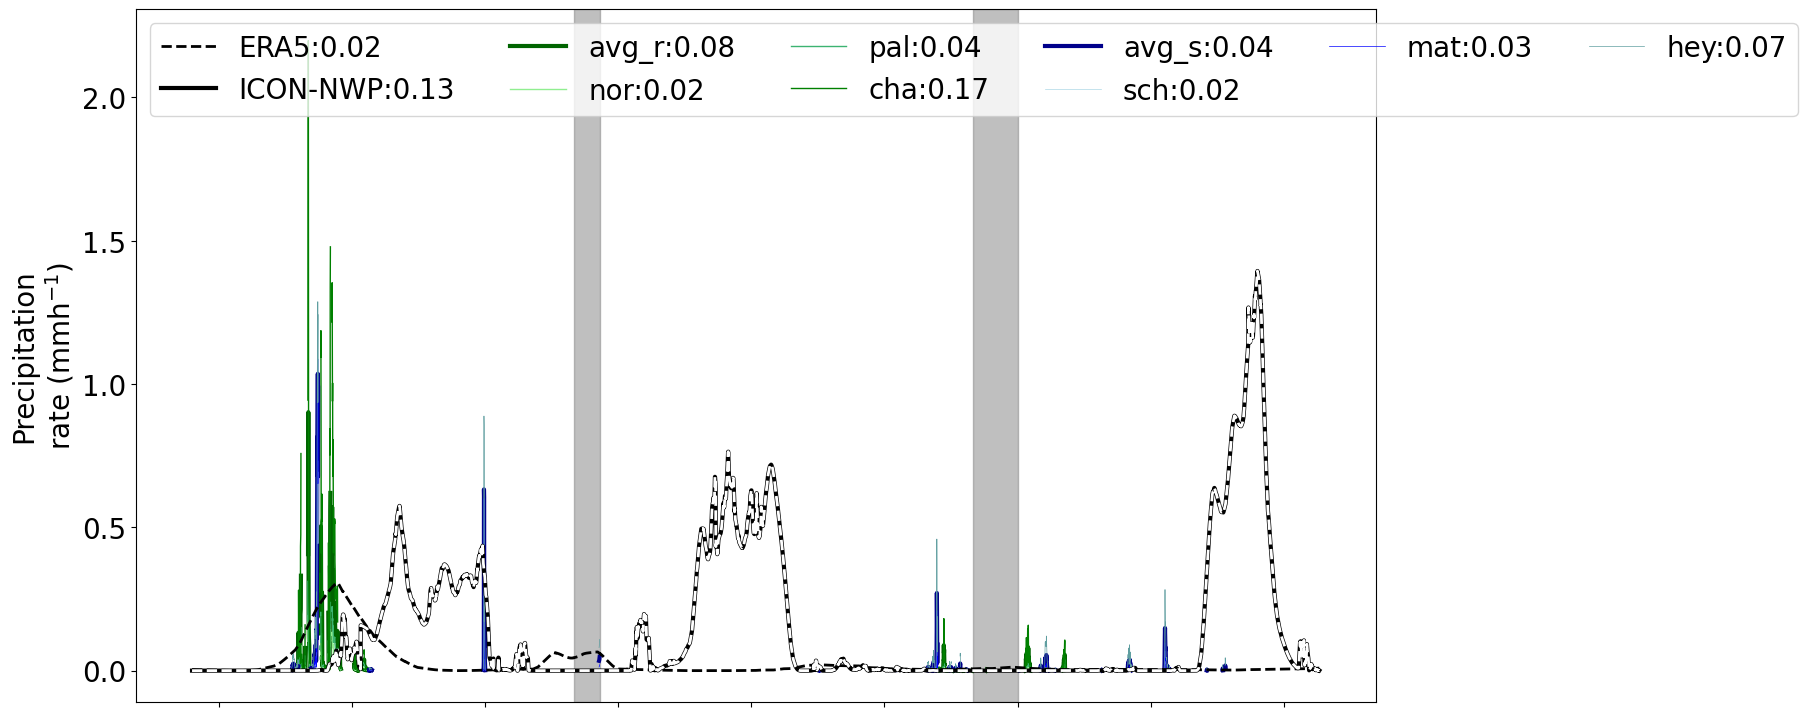

In [19]:
do_plotting=True
if do_plotting:
    Radar_Plots.plot_only_precip_rates(halo_era5,halo_icon_hmp,
                               precipitation_rate,ar_of_day,
                               inflow_times,internal_times,outflow_times,
                               radar_str,reflectivity_for_snow=reflectivity_for_snow)

## Major plots

### Preparations

In [20]:
Budget_cls   = Budgets.Moisture_Budgets()
Precip_cls   = Budgets.Surface_Precipitation("HALO_AC3",
        cmpgn_cls,flight,major_work_path,flight_dates={},
        sector_types=["warm","core","cold"],ar_of_day=ar_of_day,grid_name="ERA5",
                do_instantan=False)
# Save standard corridor precip series
Precip_cls.save_precip_rates_series(precipitation_rate,sector="all")

all precipitation saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/precip_rates/all_precip_RF06_AR_entire_2.csv


In [21]:
# General
sector_times=internal_times
sector="internal"
internal_halo_df=halo_df.loc[internal_times[0]:internal_times[-1]]
cold_sector=internal_halo_df[halo_df["longitude"]<-5].index

In [22]:
# Mainly for accessing the field data
radar_precip_rate["lat"]=halo_df["latitude"].loc[radar_precip_rate.index]
radar_precip_rate["lon"]=halo_df["longitude"].loc[radar_precip_rate.index]



In [23]:
warm_radar_precip_field,warm_icon_precip_track_field=Precip_cls.select_warm_precip(radar_precip_rate,halo_icon_hmp)
warm_radar_internal_precip=warm_radar_precip_field.loc[internal_times[0]:internal_times[-1]]
warm_radar_internal_precip[["mean_snow","mean_rain","mean_mixed"]]=\
    warm_radar_internal_precip[["mean_snow","mean_rain","mean_mixed"]].fillna(0)

warm_radar_internal_precip["rate"]=warm_radar_internal_precip["mean_snow"]+warm_radar_internal_precip["mean_rain"]+\
                                        warm_radar_internal_precip["mean_mixed"]
warm_radar_internal_precip["min_rain"]=warm_radar_internal_precip[["r_norris","r_palmer","r_chandra"]].min(axis=1).fillna(0)
warm_radar_internal_precip["max_rain"]=warm_radar_internal_precip[["r_norris","r_palmer","r_chandra"]].max(axis=1).fillna(0)
warm_radar_internal_precip["min_snow"]=warm_radar_internal_precip[["s_schoger","s_matrosov","s_heymsfield"]].min(axis=1).fillna(0)
warm_radar_internal_precip["max_snow"]=warm_radar_internal_precip[["s_schoger","s_matrosov","s_heymsfield"]].max(axis=1).fillna(0)

warm_radar_internal_precip["min_rate"]=warm_radar_internal_precip["min_rain"]+warm_radar_internal_precip["min_snow"]
warm_radar_internal_precip["max_rate"]=warm_radar_internal_precip["max_rain"]+warm_radar_internal_precip["max_snow"]

unc_period=warm_radar_internal_precip["precip_phase"]=="uncertain"
# how to deal with uncertain precipitation
warm_radar_internal_precip["min_rate"].loc[unc_period]=warm_radar_internal_precip["min_mixed"]
warm_radar_internal_precip["max_rate"].loc[unc_period]=warm_radar_internal_precip["max_mixed"]

In [24]:
# Get only internal warm precip rates
#describe warm rain rate
warm_halo_df_field=halo_df.loc[warm_radar_precip_field.index]
warm_halo_df_field
warm_icon_internal_precip=warm_icon_precip_track_field.loc[internal_times[0]:internal_times[-1]]
warm_radar_internal_precip["rate"]
warm_precip_file_name="warm_precip_"+flight[0]+"_"+ar_of_day+".csv"
Precip_cls.save_precip_rates_series(precipitation_rate,sector="warm")

warm precipitation saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/precip_rates/warm_precip_RF06_AR_entire_2.csv


### Get mean values for entire warm internal leg

In [25]:
cmpgn_cls.plot_path=cmpgn_cls.campaign_data_path+"/plots/"
haloac3_budget_plots  = Airplots.HALO_AC3_Budget_Plots(cmpgn_cls,flight,ar_of_day)

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/


In [26]:
mean_radar_internal_precip=warm_radar_internal_precip[["rate","min_rate","max_rate"]].mean(axis=0)
precip_rates=pd.Series(data=mean_radar_internal_precip.values,index=["Precip","Precip_min","Precip_max"])
haloac3_budget_plots.change_values_in_budget_df(precip_rates)

Precip        0.003679
Precip_min    0.000997
Precip_max    0.010101
dtype: float64
    IWV_dt  IWV_dt_unc     ADV_q  ADV_q_unc  DIV_mass  DIV_mass_unc    Precip  \
S1     NaN         NaN -0.278493   0.139154 -0.497346      0.056066  0.051790   
S2     NaN         NaN -0.553945   0.172242 -0.539671      0.075791  0.037786   
S3     NaN         NaN  0.593545   0.140111  0.006555      0.094550  0.045627   
S4     NaN         NaN  0.278702   0.380346  0.035408      0.105728  0.003679   

    Precip_min  Precip_max      Evap  Evap_unc  
S1    0.013120    0.112222  0.007065  0.059248  
S2    0.006882    0.096626 -0.006380  0.062227  
S3    0.012428    0.100563  0.056166  0.061512  
S4    0.000997    0.010101  0.089814  0.052798  
budget df saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/Warm_Sectors_budget_components.csv


In [27]:
# Testing
#warm_radar_internal_precip["rate"].plot()
#warm_radar_internal_precip["min_rate"].plot(ls="--")
#warm_radar_internal_precip["max_rate"].plot(ls="--")

In [28]:
# For KDE estimates 2D ICON Field for (!) warm sector
temp_clat=np.rad2deg(pd.Series(hydro_ds.clat))
cutted_clat=temp_clat[temp_clat.between(warm_halo_df_field["latitude"].min(),warm_halo_df_field["latitude"].max())]
temp_clon=np.rad2deg(pd.Series(hydro_ds.clon))
temp_clon=temp_clon.loc[cutted_clat.index]
cutted_clon=temp_clon[temp_clon.between(warm_halo_df_field["longitude"].min(),warm_halo_df_field["longitude"].max())]
cutted_icon_precip=hydro_ds["hourly_prec"].isel(ncells=cutted_clon.index)
precip_icon_series=pd.DataFrame(data=np.array(cutted_icon_precip.values[0,:]))

### Major plot class

In [29]:
haloac3_precipitation = Airplots.HALO_AC3_precipitation(cmpgn_cls,halo_df,halo_era5,halo_icon_hmp,hydro_ds,processed_radar,
            warm_radar_precip_field,warm_icon_precip_track_field,pd.DataFrame,pd.DataFrame,
            precipitation_rate,strong_precipitation_rate,radar_str,
            flight,ar_of_day,major_path=os.getcwd(),sector=sector_to_plot,calibrated_radar=calibrated_radar)

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/


### Manuscript Figure Internal leg quicklook

dBZ plotted
LDR plotted
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//plots/RF06_AR_entire_2__Precip_warm_Processed_radar.png


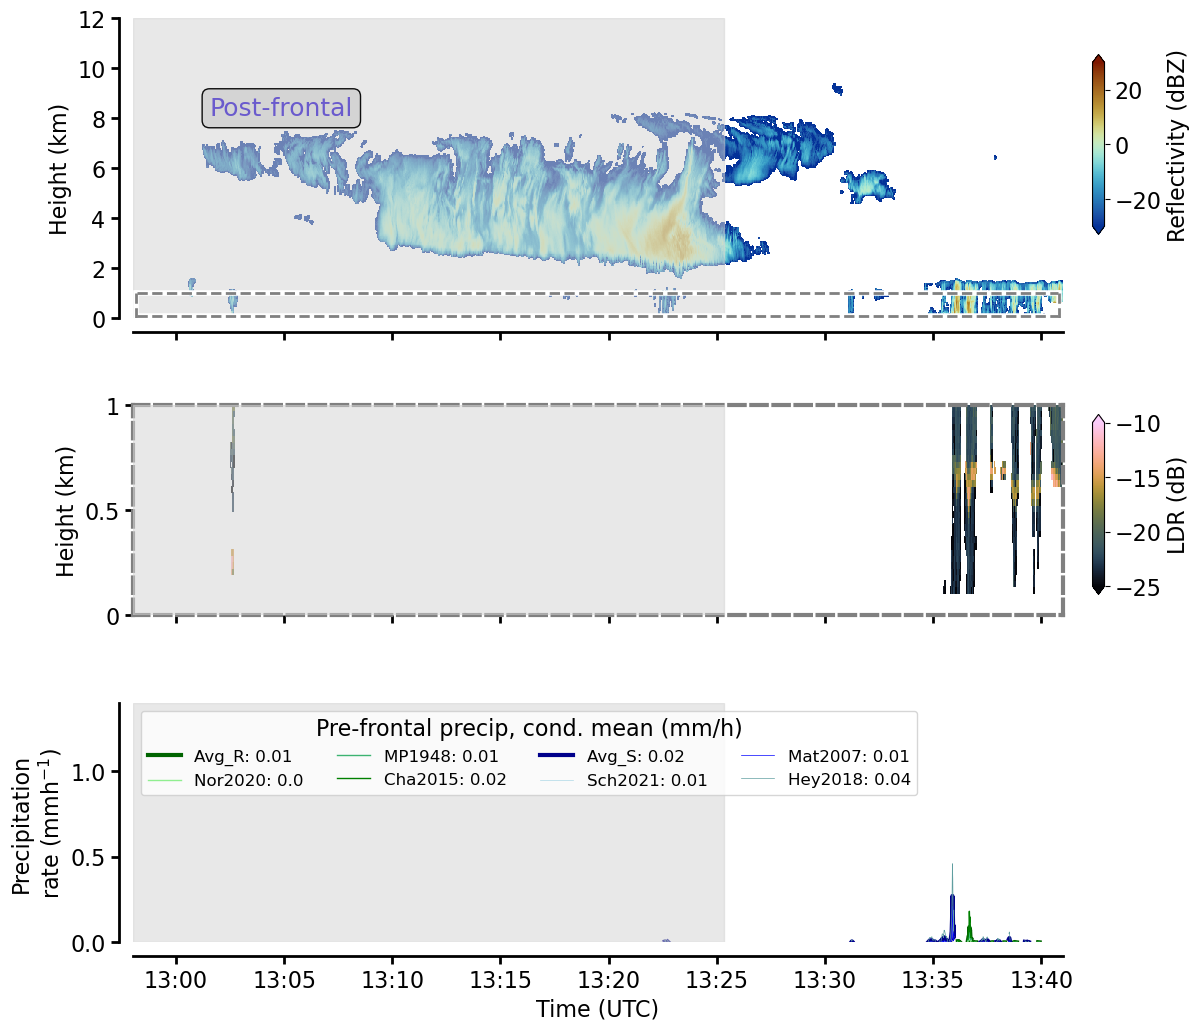

In [30]:
if flight[0]=="RF05" and ar_of_day=="AR_entire_1":
    save_as_manuscript_plot=True
else:
    save_as_manuscript_plot=False
haloac3_precipitation.plot_radar_rain_rates(sector_times,warm_radar_internal_precip,
                      sector=sector,save_as_manuscript_plot=save_as_manuscript_plot)

### Plot radar ICON intercomparison

In [31]:
#warm_radar_internal_precip["rate"].plot() --> testing

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//plots/RF06_AR_entire_2_internal_leg_precipitation_rate_comparison.pdf


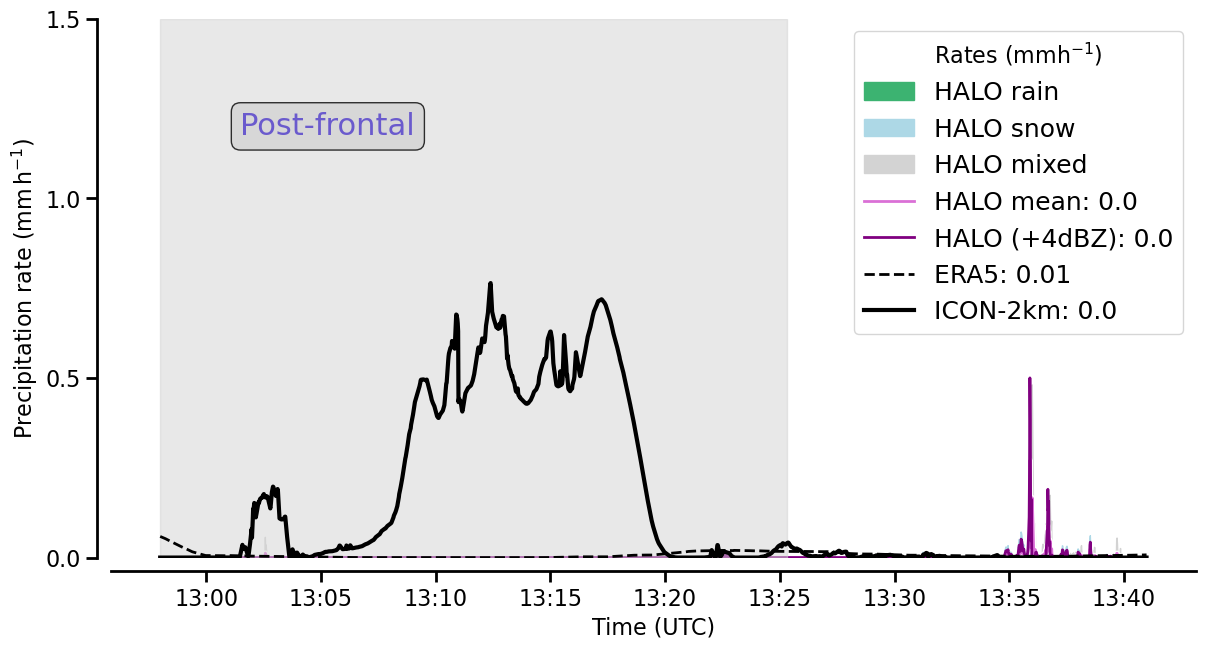

In [32]:
haloac3_precipitation.radar_model_precip_timeseries_comparison(internal_times,
                                 warm_radar_internal_precip)

## Precipitation Tendency

Look for Radar data in  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/HALO_HALO_AC3_radar_unified_*20220315_v2*.nc
Opened specific version: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc\HALO_HALO_AC3_radar_unified_RF05_20220315_v2.6.nc
Look for Radar data in  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/
C:\Users\u3007

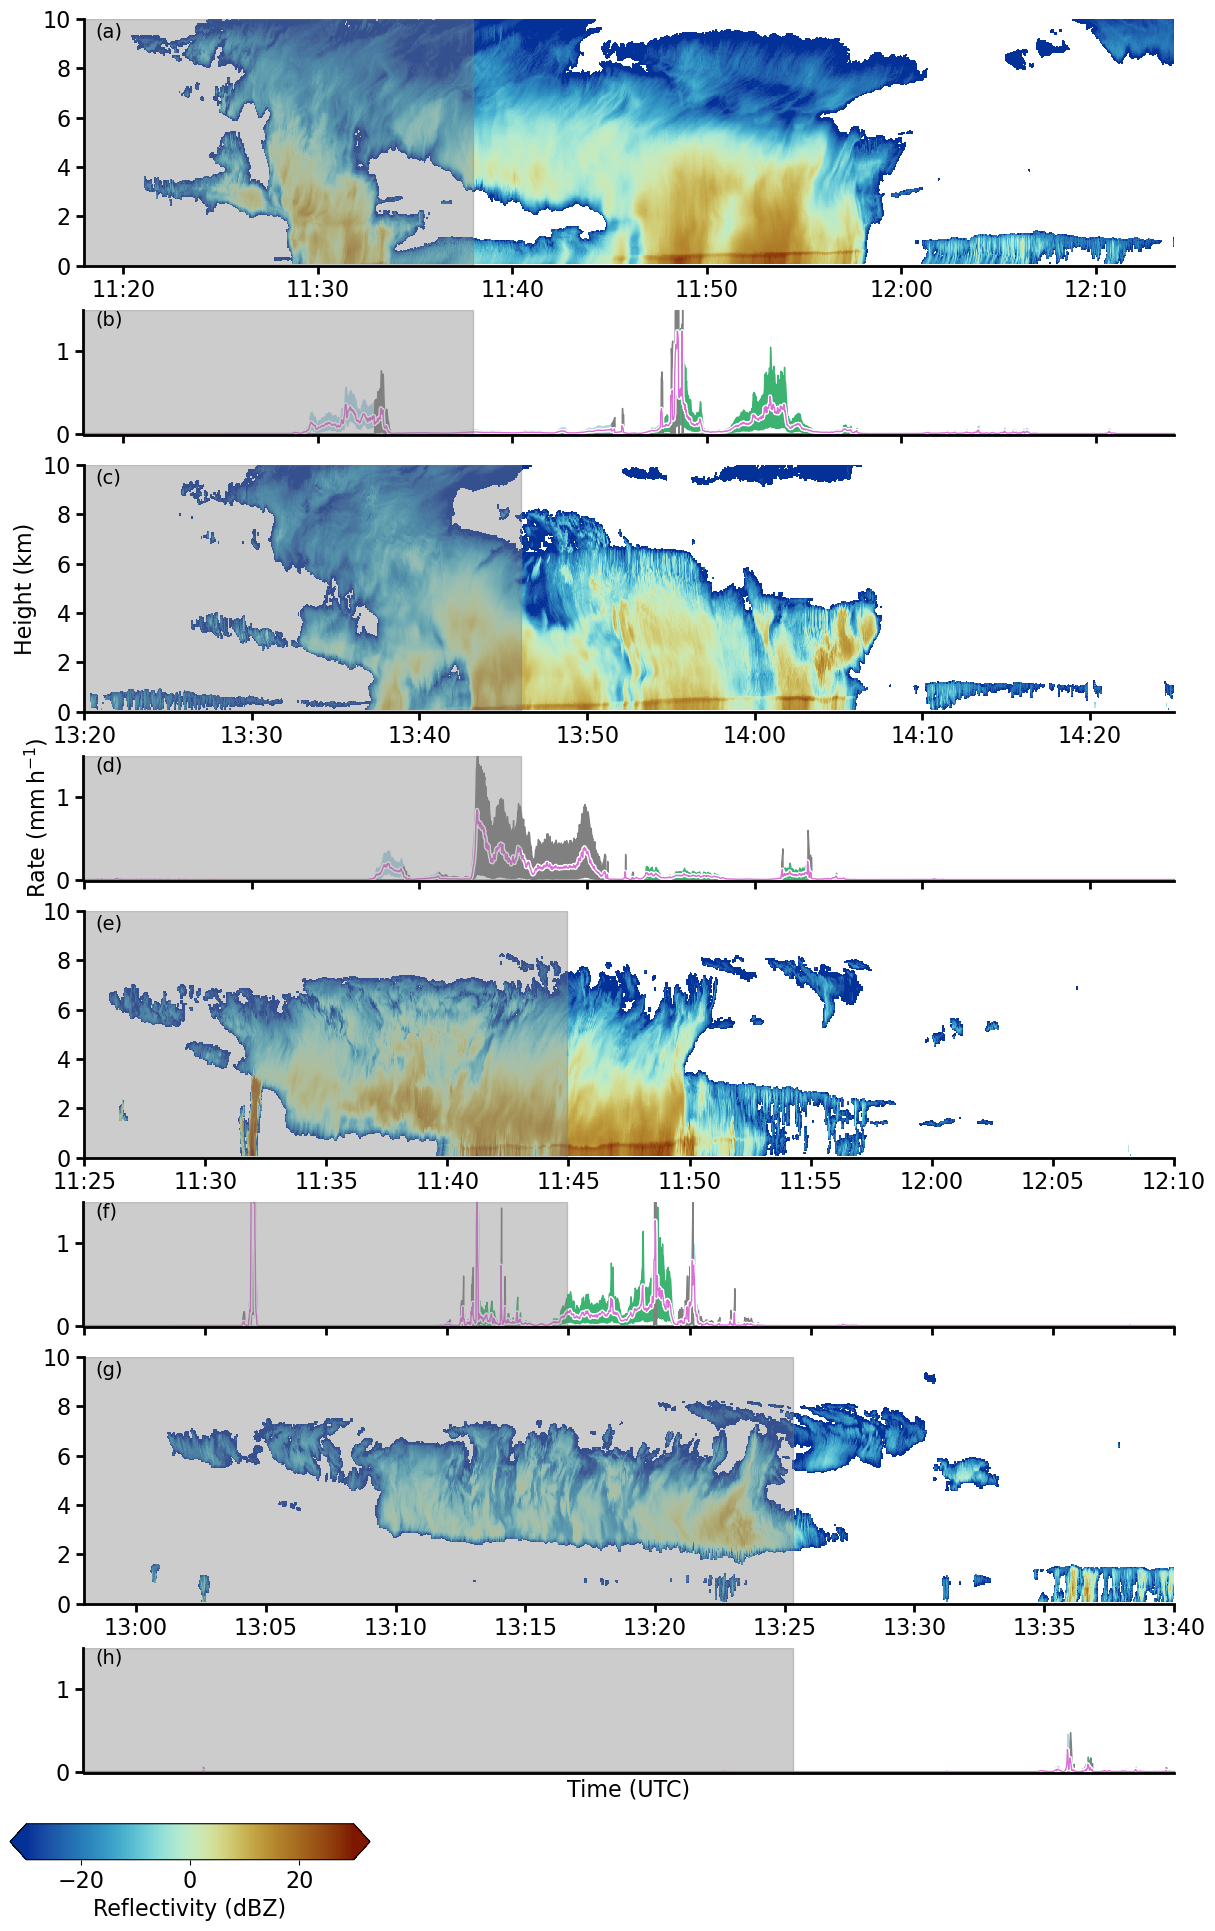

In [33]:
haloac3_precipitation.precip_sector_trends(flight_sequence)

## Precipitation Statistics Distribution

#### Precip rate spatial representativeness

In [34]:
do_plotting=False
# Entire statistics
if do_plotting:
    rain_distribution_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
                             flight,ar_of_day,"")

In [35]:
# conditional statistics
if do_plotting:
    rain_distribution_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
                             flight,ar_of_day,"",conditional_dist=True)

#### Boxplot Precip rate comparison (log-scale for rates)

In [36]:
if do_plotting:
    boxplot_precip_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate)
#radar_precip_rate

## Map precipitation horizontal field

Plots the ICON field (demonstrating the rectangle) together with the HALO precip rates.

#### Map

In [37]:
warm_radar_precip_field[["mean_snow","mean_rain"]]=warm_radar_precip_field[["mean_snow","mean_rain"]].fillna(0)
warm_radar_precip_field["rate"]=warm_radar_precip_field["mean_snow"]+warm_radar_precip_field["mean_rain"]

Figure saved as  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//plots/RF06_AR_entire_2_warm_Map_box_precipitation


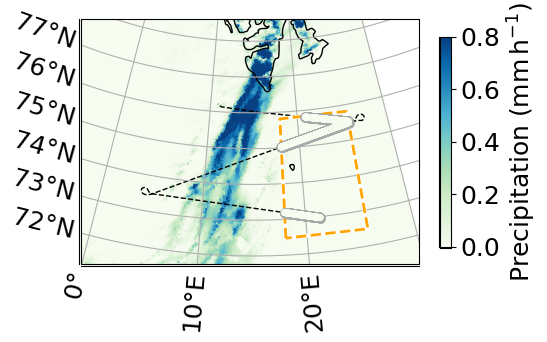

In [38]:
haloac3_precipitation.map_precipitation_region(warm_radar_precip_field,sector="warm")

#### KDE plot

In [39]:
regridded_warm_radar_precip=warm_radar_precip_field.resample("10s").mean()
regridded_warm_radar_precip=regridded_warm_radar_precip.dropna(subset = ['rate'])

conditional_dist=False

Figure saved as  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//plots/RF06_AR_entire_2_Warm_Sector_Rain_Rate_Representativeness.png


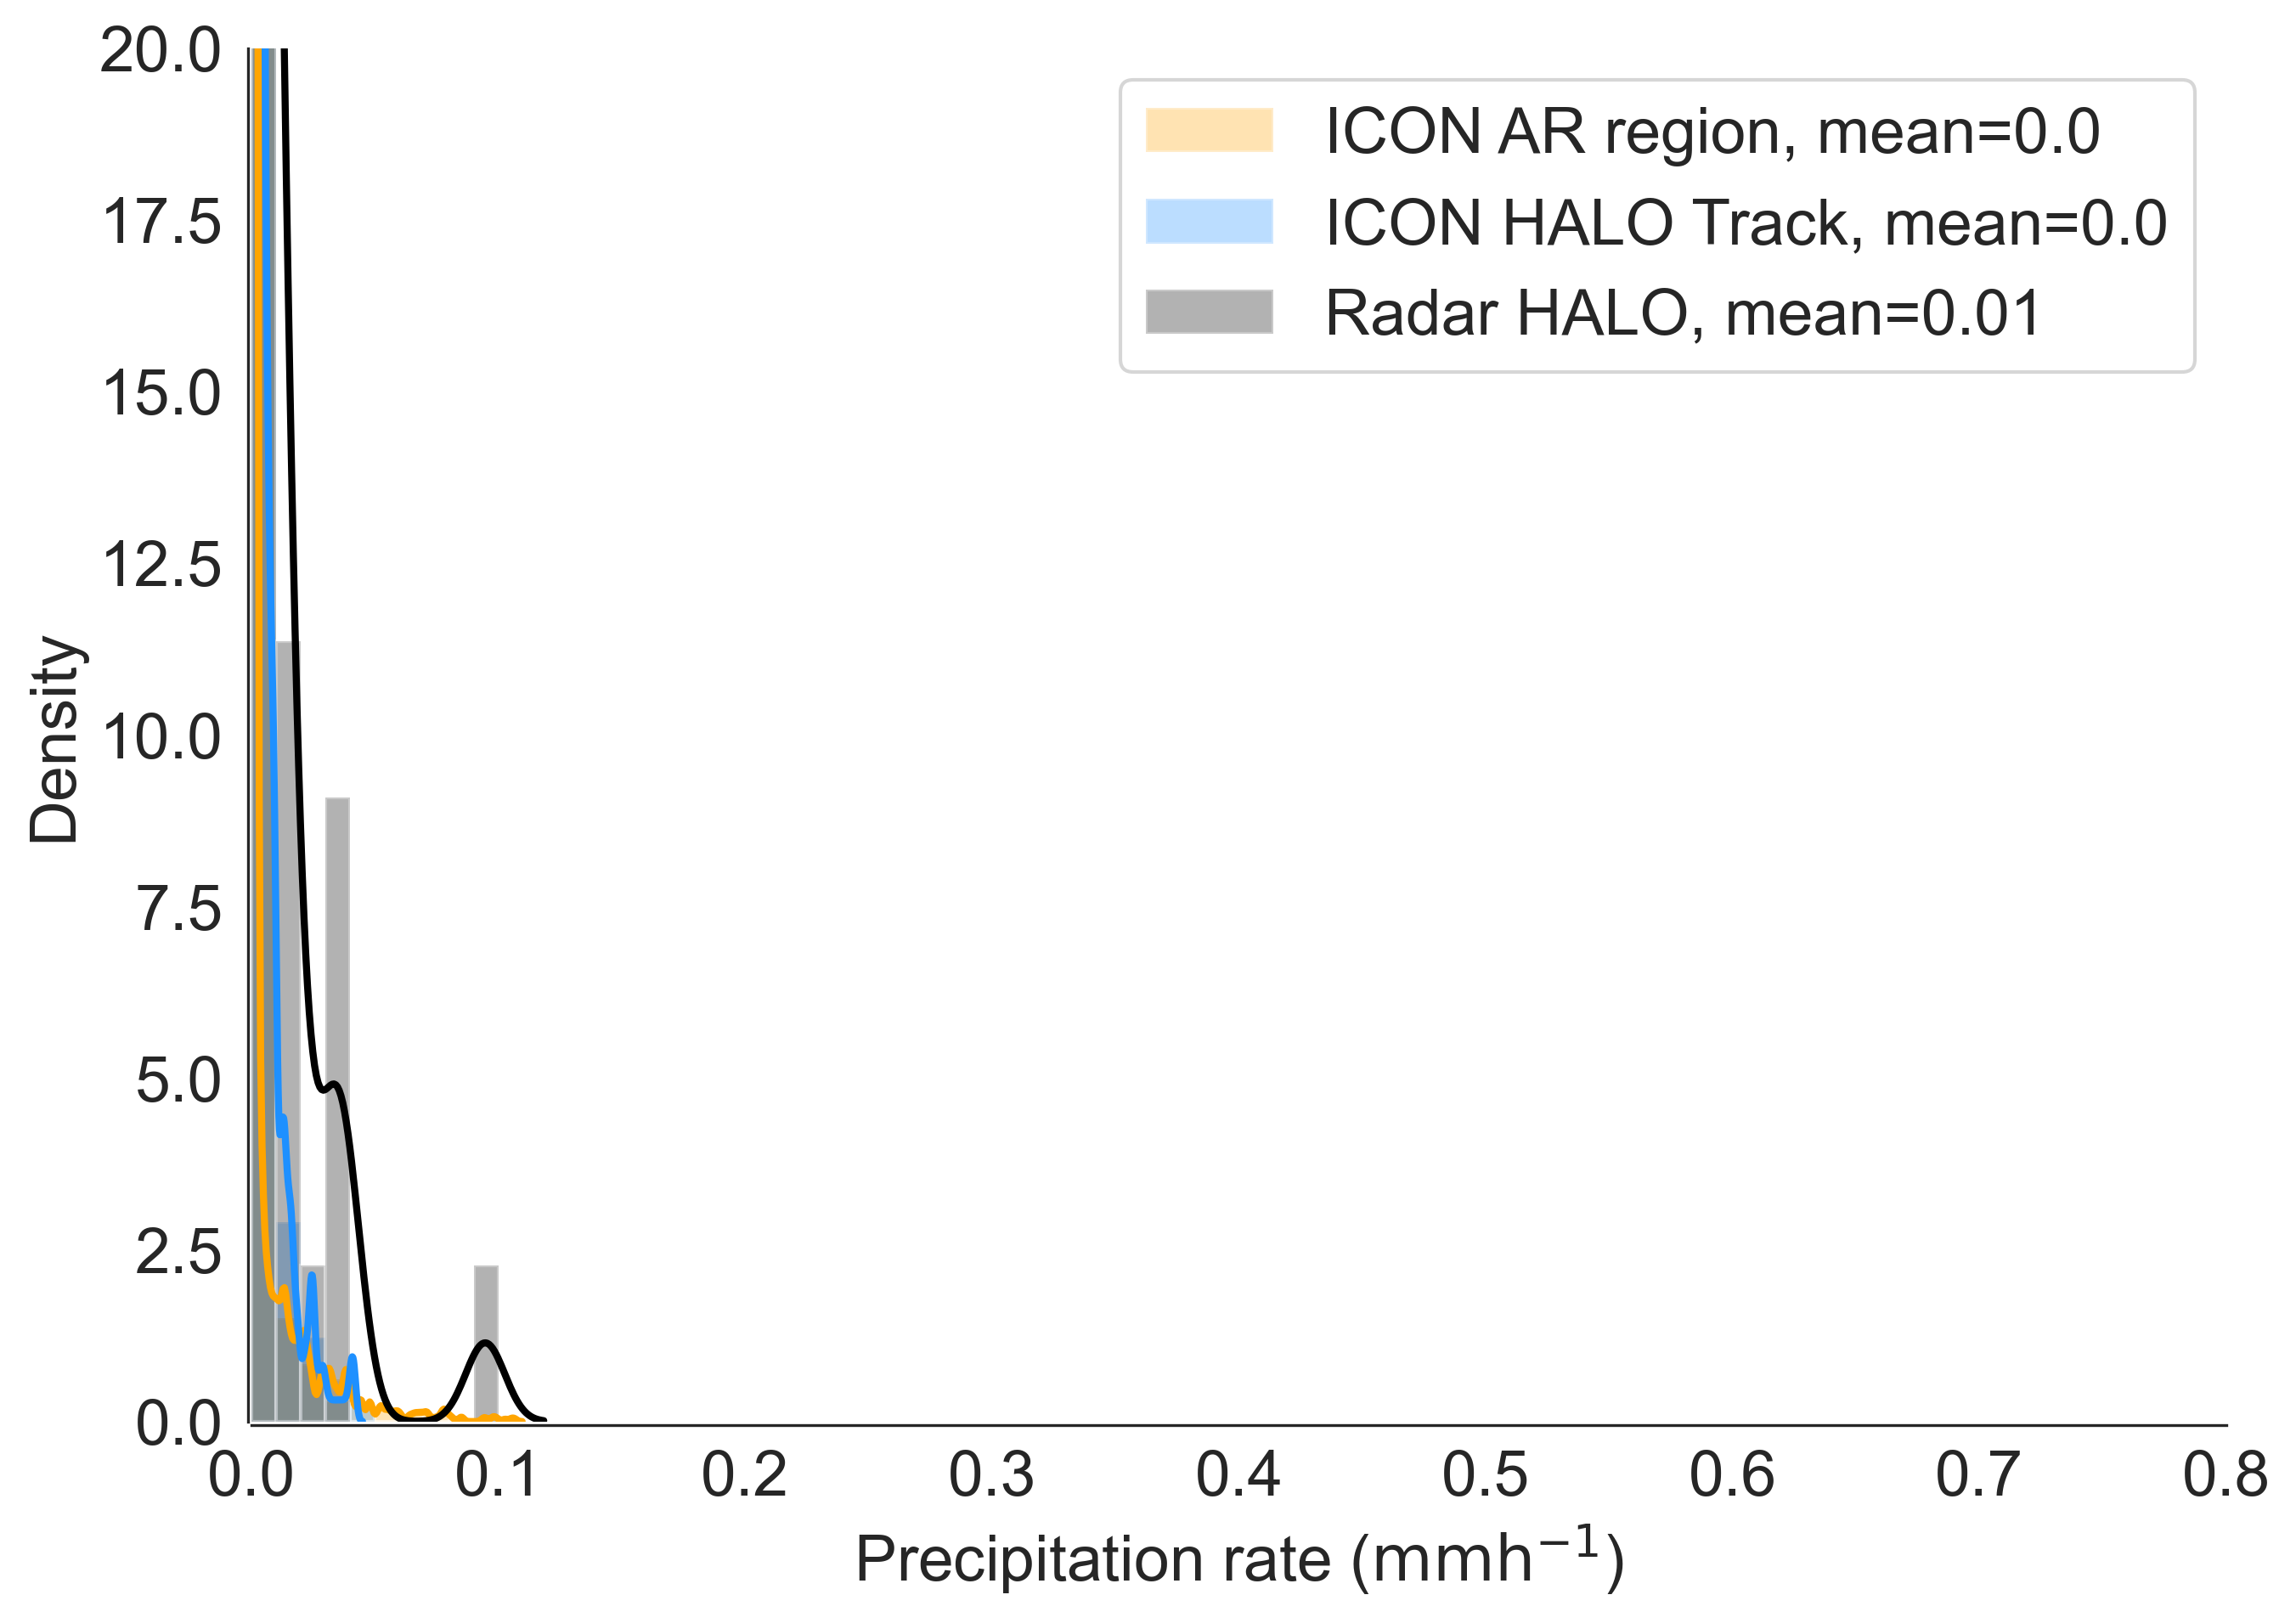

In [40]:
haloac3_precipitation.plot_kde_precip(precip_icon_series,regridded_warm_radar_precip,
                do_sensitivity_study=False,do_conditional_dist=conditional_dist,
                radar_era5=pd.DataFrame())

In [41]:
#ICON_HALO_AC3=ICON_NWP_HALO_AC3(flight,campaign,ar_sector,add_hydrometeors=add_hydrometeors)
if do_plotting:
    boxplot_precip_comparison(pd.Series(data=hydro_ds["hourly_prec"].values[0,:]),
                          halo_icon_hmp.loc[warm_radar_rain.index],halo_era5.loc[warm_radar_rain.index], warm_radar_rain,plot_path)

In [42]:
Precip_cls.save_precip_rates_series(warm_radar_internal_precip,sector="warm")

warm precipitation saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/precip_rates/warm_precip_RF06_AR_entire_2.csv


### Rain fraction

In [43]:
## Radar
print("Radar pre-frontal rain fraction:",warm_radar_internal_precip.loc[warm_radar_internal_precip["rate"]>0.0].shape[0]/\
                                          warm_radar_internal_precip.shape[0])
try:
    print("Radar post-frontal rain fraction:",cold_radar_internal_precip.loc[cold_radar_internal_precip["rate"]>0.0].shape[0]/\
          cold_radar_rain.shape[0])
except:
    print("Radar post-frontal rain fraction not defined")

Radar pre-frontal rain fraction: 0.2549707602339181
Radar post-frontal rain fraction not defined


In [44]:
print("ICON pre-frontal rain fraction:",warm_icon_internal_precip.loc[warm_icon_internal_precip["rate"]>0.0].shape[0]/\
      warm_icon_internal_precip.shape[0])
try:
    print("ICON post-frontal rain fraction:",cold_icon_internal_precip.loc[cold_icon_internal_precip["rate"]>0.0].shape[0]/\
          cold_icon_internal_precip.shape[0])
except:
    print("ICON post-frontal rain fraction not defined")

ICON pre-frontal rain fraction: 0.8678362573099415
ICON post-frontal rain fraction not defined


# Old

In [45]:
"""
#Dropsondes
take_arbitary=False
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)

sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))
relevant_sondes_dict={}

if take_arbitary:
    for sector in ["warm_sector","core","cold_sector","internal"]:
        print("Analyse frontal sector ",sector)
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]
        
        relevant_sondes_dict[sector]       = {}
        relevant_sondes_dict[sector]["in"] = sonde_times_series.loc[AR_sector_in.index[0]:AR_sector_in.index[-1]]
        relevant_sondes_dict[sector]["out"]= sonde_times_series.loc[AR_sector_out.index[0]:AR_sector_out.index[-1]]
else:
    if flight[0]=="RF05":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
            relevant_cold_sector_sondes=[4,5,6]
            relevant_internal_sondes=[7,8,13,14]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            relevant_sondes_dict["internal"]           = sonde_times_series.iloc[relevant_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[9,10,11,12,15,16,17,18]
            relevant_cold_sector_sondes=[19,20,21]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = pd.Series()#sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes]
    
    if flight[0]=="RF06":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,8,9,10]
            relevant_cold_sector_sondes=[3,4,5,10,11,12]
            relevant_warm_internal_sondes=[7,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:3]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[3:]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3:]]
            relevant_sondes_dict["internal"]           = sonde_times_series.iloc[relevant_warm_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[8,9,16,17]
            relevant_cold_sector_sondes=[10,11,12,18,19]
            relevant_warm_internal_sondes=[]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:2]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[2::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]

# -----> Location information to define the ICON rectangle box around that considers internal precipitation
### Cold sector sondes
#{'cold':                       Halo_Lat   Halo_Lon             dx             dy
# 2022-03-15 10:49:06  72.492348  -9.048471   18458.090409 -252652.694003
# 2022-03-15 10:55:47  72.644676 -11.746952  -68593.693059 -235814.302585
# 2022-03-15 11:03:29  72.776390 -14.936958 -170872.503778 -221254.651706
# 2022-03-15 12:55:00  76.801040  -4.658210  203077.456609  223630.119711
# 2022-03-15 13:05:00  76.952997  -9.839518   74207.822114  240427.441735
# 2022-03-15 13:15:00  77.000370 -15.085639  -56277.172294  245664.086848


# Warm sector sondes
#{'warm':                       Halo_Lat  Halo_Lon             dx             dy
# 2022-03-15 10:19:22  71.412415  2.119259   57426.540578 -294932.867661
# 2022-03-15 10:28:33  71.809677 -1.153413  -57855.149678 -251019.462814
# 2022-03-15 10:34:37  72.042000 -3.403830 -134599.374441 -225338.512344
# 2022-03-15 10:41:45  72.284691 -6.153736 -226219.905006 -198511.444778
# 2022-03-15 12:28:34  75.933517  8.080936  200865.746408  204829.847488
# 2022-03-15 12:36:29  76.259956  4.442734   99695.073834  240914.403915
## 2022-03-15 12:40:08  76.391243  2.720047   53472.408266  255426.827011
# 2022-03-15 12:43:47  76.510696  0.962272    7214.660040  268631.209183}
#{'warm':                       Halo_Lat   Halo_Lon             dx             dy
        # 2022-03-16 10:46:57  71.144676  17.200075   90276.849633 -115494.138234
        # 2022-03-16 10:56:15  71.200279  13.740361  -35595.821300 -109347.779592
        # 2022-03-16 11:03:35  71.197830  11.011759 -133432.507410 -109618.495992
        # 2022-03-16 12:13:00  72.973465  21.382162  168456.503395   86660.171000
        # 2022-03-16 12:21:11  73.190468  18.015015   51433.721131  110647.668101
        # 2022-03-16 12:35:11  73.430244  12.202295 -141138.745448  137152.574717}
        
warm_lon_min_max=[0,0]
warm_lat_min_max=[0,0]
"""

'\n#Dropsondes\ntake_arbitary=False\nif not "Lat" in [*Dropsondes.keys()]:\n    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0]                     for sonde in range(Dropsondes["IWV"].shape[0])]\n                    \n    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]                    for sonde in range(Dropsondes["IWV"].shape[0])]\n    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),\n                                                index=Dropsondes["IWV"].index)\n    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),\n                                                index=Dropsondes["IWV"].index)\n\nsonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))\nrelevant_sondes_dict={}\n\nif take_arbitary:\n    for sector in ["warm_sector","core","cold_sector","internal"]:\n        print("Analyse frontal sector ",sector)\n        AR_sector_in                       = AR_inflow["AR_inflow_"+sec

In [46]:
"""
# radar sector
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
        # old
        #warm_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(71.412415,76.510696)]
        #warm_radar_rain=warm_radar_rain.loc[warm_radar_rain["lon"].between(-6.153736,8.080936)]
        # new
        max_warm_lat=76.510696
        max_warm_lon=10.080936
        min_warm_lat=70.412415
        min_warm_lon=-6.153736
        
        
        #cold_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(72.492348,77.000370)]
        #cold_radar_rain=radar_precip_rate.loc[radar_precip_rate["lon"].between(-15.085639,-4.658210)]
    elif ar_of_day=="AR_entire_2":
        max_warm_lat=76.510696
        max_warm_lon=8.080936
        min_warm_lat=72.850830
        min_warm_lon=-4.379189
    else:
        Exception("no other AR sector defined")# apply sector to icon

elif flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
        max_warm_lat=73.430244
        max_warm_lon=21.382162
        min_warm_lat=71.144676
        min_warm_lon=11.011759
        
    elif ar_of_day=="AR_entire_2":
        max_warm_lat=75.811005
        max_warm_lon=25.683155
        min_warm_lat=72.973465
        min_warm_lon=18.015015
        
warm_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(min_warm_lat,max_warm_lat)]
warm_radar_rain=warm_radar_rain.loc[warm_radar_rain["lon"].between(min_warm_lon,max_warm_lon)]        

warm_icon_rain=halo_icon_hmp.loc[warm_radar_rain.index]
warm_icon_rain["rate"]=warm_icon_rain["Interp_Precip"]
try:
    cold_icon_rain=halo_icon_hmp.loc[cold_radar_rain.index]
    cold_icon_rain["rate"]=cold_icon_rain["Interp_Precip"]
except:
    print("No cold sector available")
"""

'\n# radar sector\nif flight[0]=="RF05":\n    if ar_of_day=="AR_entire_1":\n        # old\n        #warm_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(71.412415,76.510696)]\n        #warm_radar_rain=warm_radar_rain.loc[warm_radar_rain["lon"].between(-6.153736,8.080936)]\n        # new\n        max_warm_lat=76.510696\n        max_warm_lon=10.080936\n        min_warm_lat=70.412415\n        min_warm_lon=-6.153736\n        \n        \n        #cold_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(72.492348,77.000370)]\n        #cold_radar_rain=radar_precip_rate.loc[radar_precip_rate["lon"].between(-15.085639,-4.658210)]\n    elif ar_of_day=="AR_entire_2":\n        max_warm_lat=76.510696\n        max_warm_lon=8.080936\n        min_warm_lat=72.850830\n        min_warm_lon=-4.379189\n    else:\n        Exception("no other AR sector defined")# apply sector to icon\n\nelif flight[0]=="RF06":\n    if ar_of_day=="AR_entire_1":\n        max_warm_lat=73.430244\n

In [47]:
#if do_plotting:
#    plot_frontal_sector_radar_icon_rain_comparison(
#                    warm_radar_rain,cold_radar_rain,
#                    warm_icon_rain,cold_icon_rain,plot_path)

In [48]:
#if do_plotting:
#plot_frontal_sector_radar_icon_rain_comparison(
#                    warm_radar_rain,cold_radar_rain,
#                    warm_icon_rain,cold_icon_rain,plot_path,do_conditional=True)

In [49]:
#if do_plotting:
#sector_rain_halo_icon_comparison(warm_radar_rain,cold_radar_rain,warm_icon_rain,cold_icon_rain,flight,ar_of_day,sector_to_plot,plot_path)

In [50]:
"""
def map_precipitation_region(hydro_ds,processed_radar,halo_df,sector_radar_rain,plot_path,sector="warm"):
    
    
    precip_map=plt.figure(figsize=(12,12))

    if flight[0]=="RF05":
        central_lat=70
        central_lon=-10
    elif flight[0]=="RF06":
        central_lat=74
        central_lon=15
    time_step=0
    print(hydro_ds.time[time_step])
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    ax1 = plt.subplot(2,2,1,projection=ccrs.AzimuthalEquidistant(
                                central_longitude=central_lon,
                                central_latitude=central_lat))
    # IVT convergence as background based on ERA5
    C1=ax1.scatter(np.rad2deg(hydro_ds["clon"]),
            np.rad2deg(hydro_ds.clat),c=hydro_ds["hourly_prec"][time_step,:],
            cmap="GnBu",s=0.5,vmin=0.0,vmax=1,
            transform=ccrs.PlateCarree())
    cbar=plt.colorbar(C1,ax=ax1)
    cbar.set_label("Precipitation / $\mathrm{mm\,h}^{-1}$")
    ax1.set_extent([halo_df["longitude"].min()-2,halo_df["longitude"].max()+2,
                halo_df["latitude"].min()-2,halo_df["latitude"].max()+2])
    if sector!="":
        # cut the halo for the rectangle just to the specific sector
        halo_df=halo_df.loc[sector_radar_rain.index]
    if sector=="warm":
        halo_color="orange"
    else:
        halo_color="purple"
    
    ax1.plot([halo_df["longitude"].min(),halo_df["longitude"].min(),
          halo_df["longitude"].max(),halo_df["longitude"].max(),
          halo_df["longitude"].min()],
          [halo_df["latitude"].min(),halo_df["latitude"].max(),
          halo_df["latitude"].max(),halo_df["latitude"].min(),
          halo_df["latitude"].min()],
          lw=3,ls="-",color="white",
          transform=ccrs.PlateCarree(),zorder=3)
    
    ax1.plot([halo_df["longitude"].min(),halo_df["longitude"].min(),
          halo_df["longitude"].max(),halo_df["longitude"].max(),
          halo_df["longitude"].min()],
          [halo_df["latitude"].min(),halo_df["latitude"].max(),
          halo_df["latitude"].max(),halo_df["latitude"].min(),
          halo_df["latitude"].min()],
          lw=2,ls="--",color=halo_color,
          transform=ccrs.PlateCarree(),zorder=3)
    
    ax1.scatter(sector_radar_rain["lon"],sector_radar_rain["lat"],color="darkgrey",s=40,transform=ccrs.PlateCarree(),zorder=5)
    ax1.scatter(sector_radar_rain["lon"],sector_radar_rain["lat"],
                c=sector_radar_rain["rate"],cmap="GnBu",s=15,vmin=0.0,vmax=1,transform=ccrs.PlateCarree(),zorder=6)
    ax1.coastlines(resolution="50m")
    gl1=ax1.gridlines(draw_labels=True,dms=True,
                          x_inline=False,y_inline=False)
    gl1.xlabels_top = False
    gl1.ylabels_right = False
    ax1.plot(processed_radar["lon"],processed_radar["lat"],color="k",ls="--",lw=1,transform=ccrs.PlateCarree())
    fig_name="Map_box_precipitation"
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_"+fig_name
    fig_path=plot_path
    sns.despine(offset=1)
    plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as ",fig_path+fig_name)

def quicklook_sector(radar_rain,sector="warm"):
    if sector=="warm":
        halo_color="orange"
    else:
        halo_color="purple"
    plt.scatter(radar_rain["lon"],radar_rain["lat"],color=halo_color)
    #cold_icon_rain=halo_icon_hmp.loc[cold_radar_rain.index]
    #cold_icon_rain["rate"]=cold_icon_rain["Interp_Precip"]
    
    #plt.scatter(cold_radar_rain["lon"],cold_radar_rain["lat"],color="purple")
    #warm_icon_rain
    
def boxplot_precip_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
                              plot_path=os.getcwd()+"/../plots/"):
    # statistics only refer to cases when it precipitates: conditional statistics
    # Organise data
    x1 = precip_icon_series.copy()
    x1 = x1[x1>0]
    x1 = x1.dropna()
    x1.index=range(len(x1))
    x2 = halo_icon_hmp["Interp_Precip"]
    x2 = x2[x2>0]
    x2.index=range(len(x2))
    x3 = halo_era5["Interp_Precip"]
    x3 = x3[x3>0]
    x3.index = range(len(x3))
    x4 = radar_precip_rate["rate"]
    x4 = x4[x4>0]
    x4.index = range(len(x4))

    x_appended=pd.DataFrame(data=np.nan,columns=["Rates","Data","No"],
                       index=x1.index)
    x_appended["Rates"]=x1.values.astype(float)
    x_appended["Data"] ="ICON_AR_Region"
    x_appended["No"]   = 1

    x2_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x2.index)
    x2_append["Rates"]=x2.values
    x2_append["Data"] ="ICON_HALO_Track"
    x2_append["No"]  =2

    x3_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x3.index)
    x3_append["Rates"]=x3.values
    x3_append["Data"] ="ERA5_HALO_Track"
    x3_append["No"]   =3

    x4_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x4.index)
    x4_append["Rates"]=x4.values
    x4_append["Data"] ="Radar_HALO_Track"
    x4_append["No"]   =4

    x_appended=x_appended.append(x2_append,ignore_index=True)
    x_appended=x_appended.append(x3_append,ignore_index=True)
    x_appended=x_appended.append(x4_append,ignore_index=True)
    x_to_plot=x_appended.copy()#iloc[0:1000,:]
    del x_to_plot["Data"]
    print("Create boxplot")

    boxpl=sns.boxplot(x=np.log10(x_to_plot["Rates"]),
            y=x_to_plot["No"],palette={1:"dodgerblue",2:"orange",3:"deeppink",4:"k"},
            orient="h")
    boxpl.set_xlim([-5,1])
    boxpl.set_yticks([0,1,2,3],["ICON AR","ICON \nHALO Track","ERA5 \nHALO Track","Radar \n HALO Track"])
    fig_name="Boxplot_Precip_representativeness.png"
    plt.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
### KDE Plot of precip distribution

def plot_kde_precip(sector_precip_icon,warm_icon_rain,regridded_warm_radar_rain,strong_precip,
                   do_sensitivity_study=False,do_conditional_dist=False,
                   radar_era5=pd.DataFrame()):
    import seaborn as sns
    sns.set_style("white")
    
    x1 = sector_precip_icon.values
    x2 = warm_icon_rain["rate"].values
    if not radar_era5.shape[0]==0:
        x3 = radar_era5["Interp_Precip"]
    x4 = regridded_warm_radar_rain["rate"]
    
    if conditional_dist:
        x1=x1[x1>0]
        x2=x2[x2>0]
        if not radar_era5.shape[0]==0:
            x3=x3[x3>0]
        x4=x4[x4>0]
    
    kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})
    
    # Plot
    plt.figure(figsize=(10,7), dpi= 300)#
    if not radar_era5.shape[0]==0:
        sns.distplot(x3, bins=np.linspace(0,2,91),color="deeppink", 
                     label="ERA5 HALO Track", **kwargs)
    
    sns.distplot(x1, bins=np.linspace(0,1,91),color="orange",
                 label="ICON AR region, mean="+str(round(x1.mean(),2)), **kwargs)
    
    sns.distplot(x2, bins=np.linspace(0,1,91),color="dodgerblue",
                 label="ICON HALO Track, mean="+str(round(x2.mean(),2)), **kwargs)
    sns.distplot(x4, bins=np.linspace(0,1,91),color="k", 
                 label="Radar HALO, mean="+str(round(x4.mean(),2)), **kwargs)
    
    if do_sensitivity_study:
        warm_strong_precip=strong_precip_rate.loc[warm_radar_rain.index]
        warm_strong_precip=warm_strong_precip.loc[warm_radar_rain.index] 
        x5=warm_strong_precip.resample("10s").mean().dropna(subset=["rate"])["rate"]
        sns.distplot(x5, bins=np.linspace(0,1,91),color="indigo", 
                     label="Radar HALO +4 dBZ, mean="+str(round(x5.mean(),2)),**kwargs)

    plt.ylim(0,20)
    plt.xlim(0,1)
    if not conditional_dist:
        plt.xlabel("Precipitation rate / $\mathrm{mmh}^{-1}$")
    else:
        plt.xlabel("Conditional Precipitation rate / $\mathrm{mmh}^{-1}$")
    plt.legend(fontsize=12)
    file_end=".png"
    fig_name="Warm_Sector_Rain_Rate_Representativeness"
    if do_sensitivity_study:
        fig_name+="_plus_4dbz"
    fig_name+=file_end
    if conditional_dist:
        fig_name="Conditional_"+fig_name
    fig_name=flight[0]+"_"+ar_of_day+"_"+fig_name
    fig_path=plot_path
    sns.despine(offset=1)
    plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as ",fig_path+fig_name)
    return None
    
def plot_frontal_sector_radar_icon_rain_comparison(warm_radar_rain,cold_radar_rain,
                                                   warm_icon_rain,cold_icon_rain,
                                                  plot_path,do_conditional=False):
    matplotlib.rcParams.update({"font.size":18})
    # Preprocess the data
    radar_str="processed_radar"
    x1=warm_radar_rain["rate"]
    x2=warm_icon_rain["rate"]
    x3=cold_radar_rain["rate"]
    x4=cold_icon_rain["rate"]
    mean_term="mean:"
    if do_conditional:
        x1=x1.loc[x1>0.001]
        x2=x2.loc[x2>0.0]
        x3=x3.loc[x3>0.001]
        x4=x4.loc[x4>0.0]
        mean_term="cond. "+mean_term
    x1.index=range(len(x1))
    x2.index=range(len(x2))
    x3.index = range(len(x3))
    x4.index = range(len(x4))

    x_appended=pd.DataFrame(data=np.nan,columns=["Rates","Data","No"],index=x1.index)
    x_appended["Rates"]=x1.values.astype(float)
    x_appended["Data"] ="Pre-frontal Radar"
    x_appended["No"]   = 1

    x2_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],index=x2.index)
    x2_append["Rates"]=x2.values
    x2_append["Data"] ="Pre-frontal ICON"
    x2_append["No"]  =3

    x3_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],index=x3.index)
    x3_append["Rates"]=x3.values
    x3_append["Data"] ="Post-frontal Radar"
    x3_append["No"]   =2

    x4_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],index=x4.index)
    x4_append["Rates"]=x4.values
    x4_append["Data"] ="Post-frontal ICON"
    x4_append["No"]   =4

    x_appended=x_appended.append(x2_append,ignore_index=True)
    x_appended=x_appended.append(x3_append,ignore_index=True)
    x_appended=x_appended.append(x4_append,ignore_index=True)

    x_to_plot=x_appended.copy()

    del x_to_plot["Data"]
    print("Create boxplot")

    fig=plt.figure(figsize=(16,7))
    boxpl=sns.boxplot(x=x_to_plot["Rates"],
            y=x_to_plot["No"],linewidth=3,
            orient="h",palette=["darkorange","darkviolet","bisque","plum"])#,colours=["darkorange","orange","darkviolet","mediumorchid"])
    boxpl.spines['left'].set_linewidth(3)
    boxpl.spines['bottom'].set_linewidth(3)
    boxpl.text(0.5,-.25,s="cond. mean:"+str(np.round(x1.mean(),2))+"$\mathrm{mmh}^{-1}$")
    boxpl.text(0.5,.75,s="cond. mean:"+str(np.round(x3.mean(),2))+"$\mathrm{mmh}^{-1}$")
    boxpl.text(0.5,1.75,s="cond. mean:"+str(np.round(x2.mean(),2))+"$\mathrm{mmh}^{-1}$")
    boxpl.text(0.5,2.75,s="cond. mean:"+str(np.round(x4.mean(),2))+"$\mathrm{mmh}^{-1}$")

    boxpl.set_xlim([0,1])
    boxpl.set_xticks([0,.25,.5,.75,1])
    boxpl.set_yticklabels(["Radar \npre-frontal","Radar \npost-frontal","ICON \npre-frontal","ICON \npost-frontal"])
    #boxpl.xaxis.xtick_params({"length":2,"width":3})
    boxpl.set_ylabel("")
    if not do_conditional:
        boxpl.set_xlabel("Precipitation Rates ($\mathrm{mm h}^{-1}$)")
    else:
        boxpl.set_xlabel("Conditional Precipitation Rates ($\mathrm{mm h}^{-1}$)")
    sns.despine(ax=boxpl,offset=10)
    if calibrated_radar: radar_str="calibrated_and_"+radar_str
    fig_name="Rain_rate_Statistics_"+flight[0]+"_"+sector_to_plot+"_"+radar_str+"_"+reflectivity_for_snow+".png"
    if do_conditional:
        fig_name="Conditional_"+fig_name
    fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)

def plot_radar_rain_rates(sector_times,processed_radar,precipitation_rate,
                          sector="internal",add_surface_mask=False,save_as_manuscript_plot=False):
    
    import matplotlib.dates as mdates

    from matplotlib import colors
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    # Now raw_uni_radar and ds (processed uni radar) can be compared
    # via plotting
    font_size=16
    matplotlib.rcParams.update({"font.size":font_size})

    if not add_surface_mask:
        fig,axs=plt.subplots(3,1,figsize=(12,12),
                gridspec_kw=dict(height_ratios=(1,0.7,0.8)),sharex=True)
    else:
        fig,axs=plt.subplots(4,1,figsize=(12,12),
                gridspec_kw=dict(height_ratios=(1,0.7,0.8,0.1)),sharex=True)
    sector_radar=processed_radar.sel({"time":slice(sector_times[0],sector_times[-1])})

    y=np.array(sector_radar["height"][:])
    #######################################################################
    #######################################################################
    ### Processed radar
    sector_radar["dBZg"]=sector_radar["dBZg"].where(
        sector_radar["radar_flag"].isnull(), drop=True)
    sector_radar["Zg"]=sector_radar["Zg"].where(
        sector_radar["radar_flag"].isnull(), drop=True)
    sector_radar["LDRg"]=sector_radar["LDRg"].where(
                sector_radar["radar_flag"].isnull(), drop=True)

    surface_Zg=sector_radar["Zg"][:,4]
    surface_Zg=surface_Zg.where(surface_Zg!=-888.)

    #processed_radar
    time=pd.DatetimeIndex(np.array(sector_radar["dBZg"].time[:]))
    #Plotting
    C1=axs[0].pcolor(time,y,np.array(sector_radar["dBZg"][:]).T,
                    cmap=cmaeri.roma_r,vmin=-30,vmax=30)

    cax1=fig.add_axes([0.925, 0.7, 0.01, 0.15])
    cb = plt.colorbar(C1,cax=cax1,orientation='vertical',extend="both")
    cb.set_label('Reflectivity (dBZ)')
    print("dBZ plotted")

    #        if inflow_times[0]<outflow_times[-1]:
    #            axs[0].axvspan(pd.Timestamp(inflow_times[-1]),
    #               pd.Timestamp(internal_times[0]),
    #               alpha=0.5, color='grey')
    #            axs[0].axvspan(pd.Timestamp(internal_times[-1]),
    #               pd.Timestamp(outflow_times[0]),
    #               alpha=0.5, color='grey')   
    #        else:
    #            axs[0].axvspan(pd.Timestamp(outflow_times[-1]),
    #               pd.Timestamp(internal_times[0]),
    #               alpha=0.5, color='grey')
    #            axs[0].axvspan(pd.Timestamp(internal_times[-1]),
    #               pd.Timestamp(inflow_times[0]),
    #               alpha=0.5, color='grey')   
    axs[0].set_xlabel('')
    axs[0].set_yticks([0,2000,4000,6000,8000,10000,12000])
    axs[0].set_ylim([0,12000])
    axs[0].set_yticklabels(["0","2","4","6","8","10","12"])
    axs[0].set_xticklabels([])
    axs[0].set_ylabel("Height (km)")
    axs[0].axhline(xmin=0.005,xmax=0.995,y=1000,color="w",ls="-",lw=4,zorder=2)
    axs[0].axhline(xmin=0.005,xmax=0.995,y=100,color="w",ls="-",lw=4,zorder=2)
    axs[0].axvline(x=pd.Timestamp(time[10]),ymin=0,ymax=1/12,color="w",ls="-",lw=4,zorder=2)
    axs[0].axvline(x=pd.Timestamp(time[-10]),ymin=0,ymax=1/12,color="w",ls="-",lw=4,zorder=2)
    axs[0].axhline(xmin=0.005,xmax=0.995,y=1000,color="grey",ls="--",lw=2,zorder=3)
    axs[0].axhline(xmin=0.005,xmax=0.995,y=100,color="grey",ls="--",lw=2,zorder=3)
    axs[0].axvline(x=pd.Timestamp(time[10]),ymin=0,ymax=1/12,color="grey",ls="--",lw=2,zorder=3)
    axs[0].axvline(x=pd.Timestamp(time[-10]),ymin=0,ymax=1/12,color="grey",ls="--",lw=2,zorder=3)
    
    axs[0].set_ylabel("Height (km)")

    #axs[0].text(pd.Timestamp(inflow_times[0]),10000,"Inflow")
    #axs[0].text(pd.Timestamp(internal_times[0]),10000,"Internal")
    #axs[0].text(pd.Timestamp(outflow_times[0]),10000,"Outflow")
    #--------------------------------------------------------------------------------------------#
    # LDR subplot
    #--------------------------------------------------------------------------------------------#
    axs[1].spines['left'].set_color('grey')
    axs[1].spines['right'].set_color('grey')
    axs[1].spines['bottom'].set_color('grey')
    axs[1].spines['top'].set_color('grey')
    axs[1].spines['left'].set_linestyle("--")
    axs[1].spines['right'].set_linestyle("--")
    axs[1].spines['bottom'].set_linestyle("--")
    axs[1].spines['top'].set_linestyle("--")
    axs[1].spines['left'].set_linewidth(3)
    axs[1].spines['right'].set_linewidth(3)
    axs[1].spines['bottom'].set_linewidth(3)
    axs[1].spines['top'].set_linewidth(3)

    # Radar LDR
    C2=axs[1].pcolor(time,y,np.array(sector_radar["LDRg"][:]).T,
                             cmap=cmaeri.batlowK,vmin=-25, vmax=-10)        
    axs[1].set_yticks([0,500,1000])
    axs[1].set_ylim([0,1000])
    axs[1].set_yticklabels(["0","0.5","1"])
    axs[1].set_ylabel("Height (km)")
    print("LDR plotted")
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))        
    #        axs[1].text(pd.Timestamp(inflow_times[0]),10000,"Inflow")
    #        axs[1].text(pd.Timestamp(internal_times[0]),10000,"Internal")
    #        axs[1].text(pd.Timestamp(outflow_times[0]),10000,"Outflow")
    #        axs[1].set_xticklabels([])
    cax2=fig.add_axes([0.925, 0.4, 0.01, 0.15])
    cb = plt.colorbar(C2,cax=cax2,orientation='vertical',extend="both")
    cb.set_label('LDR (dB)')
    ##########################################################################
    # Precipitation rates
    ##########################################################################
    axs[2].plot(precipitation_rate["mean_rain"],lw=3,color="darkgreen",
                label="Avg_R: "+str(round(float(\
                    precipitation_rate["mean_rain"].mean()),2)))
    axs[2].plot(precipitation_rate["r_norris"],lw=1,color="lightgreen",
                label="Nor2020: "+str(round(float(\
                precipitation_rate["r_norris"].mean()),2)))

    axs[2].plot(precipitation_rate["r_palmer"],lw=1,color="mediumseagreen",
        label="MP1948: "+str(round(float(\
        precipitation_rate["r_palmer"].mean()),2)))
    axs[2].plot(precipitation_rate["r_chandra"],lw=1,color="green",
        label="Cha2015: "+str(round(float(\
        precipitation_rate["r_chandra"].mean()),2)))

    # Snow 
    axs[2].plot(precipitation_rate["mean_snow"],lw=3,color="darkblue",
                label="Avg_S: "+str(round(float(\
                precipitation_rate["mean_snow"].mean()),2)))
    axs[2].plot(precipitation_rate["s_schoger"],lw=0.5,color="lightblue",
                label="Sch2021: "+str(round(float(\
                precipitation_rate["s_schoger"].mean()),2)))
    axs[2].plot(precipitation_rate["s_matrosov"],lw=0.5,color="blue",
                label="Mat2007: "+str(round(float(\
                precipitation_rate["s_matrosov"].mean()),2)))
    axs[2].plot(precipitation_rate["s_heymsfield"],lw=0.5,color="cadetblue",
        label="Hey2018: "+str(round(float(precipitation_rate["s_heymsfield"].mean()),2)))

    axs[2].set_ylim([0,1.4])
    axs[2].legend(loc="upper left",ncol=4,fontsize=font_size-2)
    axs[2].set_xticks=axs[1].get_xticks()
    axs[2].set_ylabel("Precipitation\nrate ($\mathrm{mmh}^{-1}$)")

    sns.despine(ax=axs[0],offset=10)
    sns.despine(offset=10,ax=axs[2])
    if not add_surface_mask:
        axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

        for a, axis in enumerate(axs[0:3]):
            if not a==1:
                axis.spines["left"].set_linewidth(2)
                axis.spines["bottom"].set_linewidth(2)
            axis.tick_params(axis="x",length=6,width=2)
            axis.tick_params(axis="y",length=6,width=2)
            
        axs[2].tick_params(axis="x",length=6,width=2)
        axs[2].set_xlabel("Time (UTC)")

    else: 
        axs[2].set_xticklabels([])
        # Add surface mask
        # plot AMSR2 sea ice concentration
        fs = 14
        fs_small = fs - 2
        fs_dwarf = fs - 4
        marker_size = 15

        bah_df=pd.DataFrame()
        bah_df["sea_ice"]=pd.Series(data=np.array(\
                            internal_radar["radar_flag"][:,0]),
                            index=pd.DatetimeIndex(np.array(internal_radar.time[:])))
        blue_colorbar=cm.get_cmap('Blues_r', 22)
        blue_cb=blue_colorbar(np.linspace(0, 1, 22))
        brown_rgb = np.array(colors.hex2color(colors.cnames['brown']))
        blue_cb[:2, :] = [*brown_rgb,1]
        newcmp = ListedColormap(blue_cb)
        im = axs[3].pcolormesh(np.array([\
                pd.DatetimeIndex(bah_df["sea_ice"].index),
                pd.DatetimeIndex(bah_df["sea_ice"].index)]),
                np.array([0, 1]),
                np.tile(np.array(bah_df["sea_ice"].values),(2,1)),
                cmap=newcmp, vmin=-0.1, vmax=1,
                shading='auto')

        cax = fig.add_axes([0.7, 0.08, 0.1, axs[3].get_position().height])
        C1=fig.colorbar(im, cax=cax, orientation='horizontal')
        C1.set_label(label='Sea ice [%]',fontsize=fs_small)
        C1.ax.tick_params(labelsize=fs_small)
        axs[3].tick_params(axis='x', labelleft=False, 
                           left=False,labelsize=fs_small)
        axs[3].tick_params(axis='y', labelleft=False, left=False)
        axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

        for a,axis in enumerate(axs[0:3]):
            if not a==1:
                axis.spines["left"].set_linewidth(3)
                axis.spines["bottom"].set_linewidth(3)
            axis.tick_params(axis="x",length=6,width=2)
            axis.tick_params(axis="y",length=6,width=2)

        axs[3].tick_params(axis="x",length=6,width=2)
        axs[3].set_xlabel("Time (UTC)")
    # Limit axis spacing:
    plt.subplots_adjust(hspace=0.35)			# removes space between subplots
    #box = axs[3].get_position()        
    #box.y0 = box.y0 + 0.025
    #box.y1 = box.y1 + 0.025        
    #axs[3]=axs[3].set_position(box)
    fig_name=flight[0]+"_WS1_Precip_"+sector+"_"+\
                "Processed_radar.png"
    if save_as_manuscript_plot:
        fig_name="Fig07_"+fig_name
    fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
    
def radar_model_precip_timeseries_comparison(precipitation_rate,strong_precip_rate,internal_times,
                                 halo_era5,halo_icon_hmp):
    
    import matplotlib.dates as mdates
    radar_str="Processed and calibrated radar"
    # cut to internal leg
    internal_precipitation_rate=precipitation_rate.loc[internal_times[0]:internal_times[-1]]
    strong_internal_precip_rate=strong_precip_rate.loc[internal_times[0]:internal_times[-1]]
    internal_era5 = halo_era5.loc[internal_times[0]:internal_times[-1]]
    internal_icon = halo_icon_hmp.loc[internal_times[0]:internal_times[-1]]

    internal_rain_rate=internal_precipitation_rate[["r_norris","r_palmer",
                                            "r_chandra"]]
    internal_snow_rate=internal_precipitation_rate[["s_schoger","s_matrosov",
                                                "s_heymsfield"]]
    precip_rate_fig=plt.figure(figsize=(14,7))
    ax1=precip_rate_fig.add_subplot(111)
    ax1.fill_between(internal_rain_rate.index,
        internal_rain_rate.min(axis=1).values,
        y2=internal_rain_rate.max(axis=1).values,
        color="mediumseagreen",label="HALO rain")
    ax1.fill_between(internal_snow_rate.index,
        internal_snow_rate.min(axis=1).values,
        y2=internal_snow_rate.max(axis=1).values,
        color="lightblue",label="HALO snow")
    ax1.plot(internal_precipitation_rate.index,
             internal_precipitation_rate["rate"].values,color="white",lw=4)
    ax1.plot(internal_precipitation_rate.index,
             internal_precipitation_rate["rate"].values,color="orchid",lw=2,
             label="HALO mean: "+str(round(float(internal_precipitation_rate["rate"].loc[cold_sector[-1]::].mean()),2)))
    ###
    ax1.plot(strong_internal_precip_rate.index,
             strong_internal_precip_rate["rate"].values,
             color="purple",lw=2,
             label="HALO (+4dBZ): "+str(round(float(strong_internal_precip_rate["rate"].loc[cold_sector[-1]::].mean()),2)))
    ###
    ax1.plot(internal_era5["Interp_Precip"],lw=2,ls="--",color="k",label="ERA5: "+\
        str(round(float(internal_era5["Interp_Precip"].loc[cold_sector[-1]::].mean()),2)),zorder=5)
    ax1.plot(internal_icon["Interp_Precip"],lw=3,ls="-",color="k",label="ICON-2km: "+\
        str(round(float(internal_icon["Interp_Precip"].loc[cold_sector[-1]::].mean()),2)),zorder=6)
    ax1.axvspan(pd.Timestamp(cold_sector[0]),
                   pd.Timestamp(cold_sector[-1]),
                   alpha=0.3, color='lightgrey')
    ax1.text(0.2,0.8,"Post-frontal",bbox=dict(facecolor='lightgrey',edgecolor="k",boxstyle="round",alpha=0.8),
             ha='center',color="slateblue", va='center',fontsize=22,transform=ax1.transAxes)


    ax1.legend()
    sns.despine(offset=10)
    ax1.spines["left"].set_linewidth(2)
    ax1.spines["bottom"].set_linewidth(2)
    ax1.set_xlabel("Time (UTC)")
    ax1.set_yticks([0,0.5,1.0,1.5])
    ax1.set_ylim([0,1.5])
    ax1.set_ylabel("Precipitation rate ($\mathrm{mm\,h}^{-1}$)")
    ax1.tick_params("x",length=8,width=2)
    ax1.tick_params("y",length=8,width=2)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig_path=os.getcwd()+"/../plots/"
    fig_name="Fig16_internal_leg_precipitation_rate_comparison.pdf"
    precip_rate_fig.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",fig_path+fig_name)
    

# Old
#def rain_distribution_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
#                                 flight,ar_of_day,sector_to_plot,
#                                conditional_dist=False):
#    import seaborn as sns
#    sns.set_style("white")#
#
#    x1 = precip_icon_series.copy()
#    x2 = halo_icon_hmp["Interp_Precip"]
#    x3 = halo_era5["Interp_Precip"]
#    x4 = radar_precip_rate["rate"]
#    
#    if conditional_dist:
#        x1=x1[x1>0]
#        x2=x2[x2>0]
#        x3=x3[x3>0]
#        x4=x4[x4>0]
#    # Plot
#    kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})

#    plt.figure(figsize=(10,7), dpi= 300)#
#    sns.distplot(x3, bins=np.linspace(0,2,91),color="deeppink", label="ERA5 HALO Track", **kwargs)
#    sns.distplot(x1, bins=np.linspace(0,2,91),color="dodgerblue", label="ICON AR region", **kwargs)
#    sns.distplot(x2, bins=np.linspace(0,2,91),color="orange", label="ICON HALO Track", **kwargs)
#    sns.distplot(x4, bins=np.linspace(0,2,91),color="k", label="Radar HALO Track", **kwargs)
#    plt.ylim(0,50)
#    plt.xlim(0,1)
#    if not conditional_dist:
#       plt.xlabel("Precipitation rate / $\mathrm{mmh}^{-1}$")
#   else:
#        plt.xlabel("Conditional Precipitation rate / $\mathrm{mmh}^{-1}$")
#    
#    plt.legend()
#    fig_name="Rain_rate_representativeness.png"
#    if conditional_dist:
#        fig_name="Conditional_"+fig_name
#    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_"+fig_name
#    fig_path=plot_path
#    sns.despine(offset=1)
#    plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
#    print("Figure saved as ",fig_path+fig_name)

#def sector_rain_halo_icon_comparison(warm_radar_rain,cold_radar_rain,
#                                    warm_icon_rain,cold_icon_rain,
#                                    flight,ar_of_day,sector_to_plot,
#                                     plot_path):
#    x1=warm_radar_rain["rate"]#.loc[warm_radar_rain["rate"]>0.001]
#    x2=warm_icon_rain["rate"]#.loc[warm_icon_rain["rate"]>0.0]
#    x3=cold_radar_rain["rate"]#.loc[cold_radar_rain["rate"]>0.001]
#    x4=cold_icon_rain["rate"]#.loc[cold_icon_rain["rate"]>0.0]
#
#    x1.index=range(len(x1))
#    x2.index=range(len(x2))
#    x3.index = range(len(x3))
#    x4.index = range(len(x4))
#    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
#    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(12,12))#
#
#    import seaborn as sns
#    sns.set_style("white")
#    import matplotlib
#    matplotlib.rcParams.update({"font.size":22})
#    # Plot
#    kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})
#    sns.distplot(x3, bins=np.linspace(0,2,91),color="darkorange", label="Pre-frontal radar",ax=ax_hist, **kwargs)
#    sns.distplot(x1, bins=np.linspace(0,2,91),color="orange", label="Pre-frontal ICON",ax=ax_hist, **kwargs)
#    sns.distplot(x2, bins=np.linspace(0,2,91),color="darkviolet", label="Post-frontal radar", ax=ax_hist, **kwargs)
#    sns.distplot(x4, bins=np.linspace(0,2,91),color="mediumorchid", label="Post-frontal ICON", ax=ax_hist,**kwargs)
#    plt.ylim(0,50)
#    plt.xlim(0,1)
#    plt.xlabel("Conditional Precipitation rate / $\mathrm{mmh}^{-1}$")
#    plt.legend()
#    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_Conditional_Rain_rate_representativeness.png"
#    fig_path=plot_path
#    sns.despine(offset=1)
#    plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
#    print("Figure saved as ",fig_path+fig_name)
"""    

'\ndef map_precipitation_region(hydro_ds,processed_radar,halo_df,sector_radar_rain,plot_path,sector="warm"):\n    \n    \n    precip_map=plt.figure(figsize=(12,12))\n\n    if flight[0]=="RF05":\n        central_lat=70\n        central_lon=-10\n    elif flight[0]=="RF06":\n        central_lat=74\n        central_lon=15\n    time_step=0\n    print(hydro_ds.time[time_step])\n    from mpl_toolkits.axes_grid1.inset_locator import inset_axes\n    ax1 = plt.subplot(2,2,1,projection=ccrs.AzimuthalEquidistant(\n                                central_longitude=central_lon,\n                                central_latitude=central_lat))\n    # IVT convergence as background based on ERA5\n    C1=ax1.scatter(np.rad2deg(hydro_ds["clon"]),\n            np.rad2deg(hydro_ds.clat),c=hydro_ds["hourly_prec"][time_step,:],\n            cmap="GnBu",s=0.5,vmin=0.0,vmax=1,\n            transform=ccrs.PlateCarree())\n    cbar=plt.colorbar(C1,ax=ax1)\n    cbar.set_label("Precipitation / $\\mathrm{mm\\,h}^{-1}$